<a href="https://colab.research.google.com/github/marah-ghanem/Waste_Classification_Project/blob/main/Waste_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mareh Aboghanem

**WASTE CLASSIFICATION**
PROBLEM
Waste management is a big problem in our country. Most of the wastes end up in landfills. This leads to many issues like:

*   Increase in landfills
*   Eutrophication
*   Consumption of toxic waste by animals.
*   Leachate.
*   Increase in toxinsLand.
*   water and air pollution.


# Load The Dataset & Preprocessing :

### IMPORT LIBRARIES

In [1]:
!pip install Keras-Preprocessing
#!pip install tensorflow
import os
import glob
import shutil
import random
import numpy as np
import skimage.io
import tensorflow
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imshow
from tensorflow.keras.models import Sequential
from keras_preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


### Load DATASET

Dataset is divided into train data (85%) and test data (15%)

*   Training data - 22564 images
*   Test data - 2513 images




In [2]:
! pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/techsash/waste-classification-data")

100%|██████████| 427M/427M [00:05<00:00, 75.6MB/s]


In [3]:
data ='/content/waste-classification-data/dataset/DATASET'
train_data_dir = '/content/waste-classification-data/dataset/DATASET/TRAIN'
test_data_dir = '/content/waste-classification-data/dataset/DATASET/TEST'

There is imbalance between the Two Classes [O,R] so I did
data augmentation:



---


1. UpSampling :Balance the 'recycle' class with the 'organic' class by

adding randomly selected 'recycle' samples to reach 12,565 samples.




---

In [4]:
original_Class_R = '/content/waste-classification-data/DATASET/TRAIN/R'
augmented_Class_R = '/content/waste-classification-data/DATASET/TRAIN/R'
os.makedirs(augmented_Class_R, exist_ok=True)
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
original_image_R_file =[os.path.join(original_Class_R, filename) for filename in os.listdir(original_Class_R)]
addi_img_needed = 12565 - len(original_image_R_file)
for i in range(addi_img_needed):
    random_originalR_img = random.choice(original_image_R_file)
    img = load_img(random_originalR_img)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    for batch in datagen.flow(x, batch_size=1):
        augmented_img = batch[0].astype('uint8')
        new_image_path = os.path.join(augmented_Class_R, f'augmented_image_{i}.jpg')
        img_to_save = Image.fromarray(augmented_img)
        img_to_save.save(new_image_path)
        break
print(f"total in augmented: {len(os.listdir(augmented_Class_R))}")

total in augmented: 12565


In [5]:
Class_R = '/content/waste-classification-data/DATASET/TRAIN/R/'
file_extension = '*.jpg'
match_img = glob.glob(os.path.join(Class_R, file_extension))
num_Class_R = len(match_img)
num_Class_R

12565



---


2. Preprocess dataset by rescaling pixel values, applying zoom and rotation transformations, and adding horizontal and vertical flips. Also, split the dataset into training and validation sets with an 80-20 split ratio.



---

In [6]:
classes = ['O','R']
new_height = 224
new_width = 224
batch_size = 128

In [7]:
param = {
    "rescale": 1.0 / 255.0,
    "zoom_range": 0.4,
    "rotation_range": 10,
    "horizontal_flip": True,
    "vertical_flip": True,
    "validation_split": 0.2,
}

In [8]:
train_pp_aug = ImageDataGenerator(**param)

In [9]:
train_generator = train_pp_aug.flow_from_directory(
    train_data_dir,
    target_size=(new_height, new_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

Found 18052 images belonging to 2 classes.


In [10]:
vaild_param = {
    "rescale": 1.0 / 255.0,
    "validation_split": 0.2,
}

In [11]:
valid_pp = ImageDataGenerator(**vaild_param)

In [12]:
validation_generator = valid_pp.flow_from_directory(
    train_data_dir,
    target_size=(new_height, new_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 4512 images belonging to 2 classes.


In [13]:
test_pp = ImageDataGenerator(rescale=1.0/255.0)

In [14]:
test_generator = test_pp.flow_from_directory(
    test_data_dir,
    target_size=(new_height, new_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2513 images belonging to 2 classes.


# MODEL

This model is a fine-tuned VGG16-based convolutional neural network (CNN) with custom 5 dense layers (1024, 512, and 256 filters) incorporating batch normalization, ReLU activation, and dropout (20% rate). It is designed for binary waste classification tasks.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
VGG16_model = VGG16(input_shape=(new_height,new_width,3),include_top=False,weights="imagenet")
for layer in VGG16_model.layers:
    layer.trainable=False

58889256/58889256 [==============================] - 1s 0us/step


In [53]:
model=Sequential()
model.add(VGG16_model)
model.add(Dropout(0.2))

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))

model.load_weights('/content/drive/MyDrive/lastw.h5')

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_18 (Dropout)        (None, 7, 7, 512)         0         
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_15 (Ba  (None, 25088)             100352    
 tchNormalization)                                               
                                                                 
 dense_18 (Dense)            (None, 1024)              25691136  
                                                                 
 activation_15 (Activation)  (None, 1024)              0         
                                                      

In [55]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC


optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',metrics=[AUC(name='auc')],optimizer=optimizer)


In [48]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 4,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)

In [50]:
model_history=model.fit(train_generator,validation_data=validation_generator,epochs = 20,callbacks =[earlystopping, checkpoint],verbose = 1)

Epoch 1/20
142/142 [==============================] - ETA: 0s - loss: 0.1955 - auc: 0.9758
Epoch 1: val_auc improved from -inf to 0.95166, saving model to ./best_weights.hdf5
142/142 [==============================] - 287s 2s/step - loss: 0.1955 - auc: 0.9758 - val_loss: 0.3414 - val_auc: 0.9517
Epoch 2/20
142/142 [==============================] - ETA: 0s - loss: 0.1821 - auc: 0.9790
Epoch 2: val_auc improved from 0.95166 to 0.95226, saving model to ./best_weights.hdf5
142/142 [==============================] - 275s 2s/step - loss: 0.1821 - auc: 0.9790 - val_loss: 0.3128 - val_auc: 0.9523
Epoch 3/20
142/142 [==============================] - ETA: 0s - loss: 0.1737 - auc: 0.9809
Epoch 3: val_auc improved from 0.95226 to 0.95292, saving model to ./best_weights.hdf5
142/142 [==============================] - 268s 2s/step - loss: 0.1737 - auc: 0.9809 - val_loss: 0.3104 - val_auc: 0.9529
Epoch 4/20
142/142 [==============================] - ETA: 0s - loss: 0.1716 - auc: 0.9815
Epoch 4: val

In [51]:
import shutil
model.save_weights('modelwls.h5')
shutil.copy("modelwls.h5","/content/drive/MyDrive/")

'/content/drive/MyDrive/modelwls.h5'

## MODEL EVALUATION

In [56]:
model.evaluate(test_generator)

20/20 [==============================] - 11s 513ms/step - loss: 0.2976 - auc: 0.9559


[0.29755932092666626, 0.9558748006820679]

In [64]:
test_predictions = model.predict(test_generator)

20/20 [==============================] - 10s 488ms/step


In [65]:
test_labels=[]
test_paths = []

In [66]:
def loading_preprocessing_ImagePerdict(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (new_height, new_width))
    return image

In [67]:
tst_predictions = np.array(test_predictions)
threshold = 0.5
test_predictions = (tst_predictions > threshold).astype(np.int32)

for class_name in classes:
    class_dir = os.path.join(test_data_dir, class_name)
    for filename in os.listdir(class_dir):
        test_paths.append(os.path.join(class_dir, filename))
        test_labels.append(classes.index(class_name))
test_labels = np.array(test_labels)


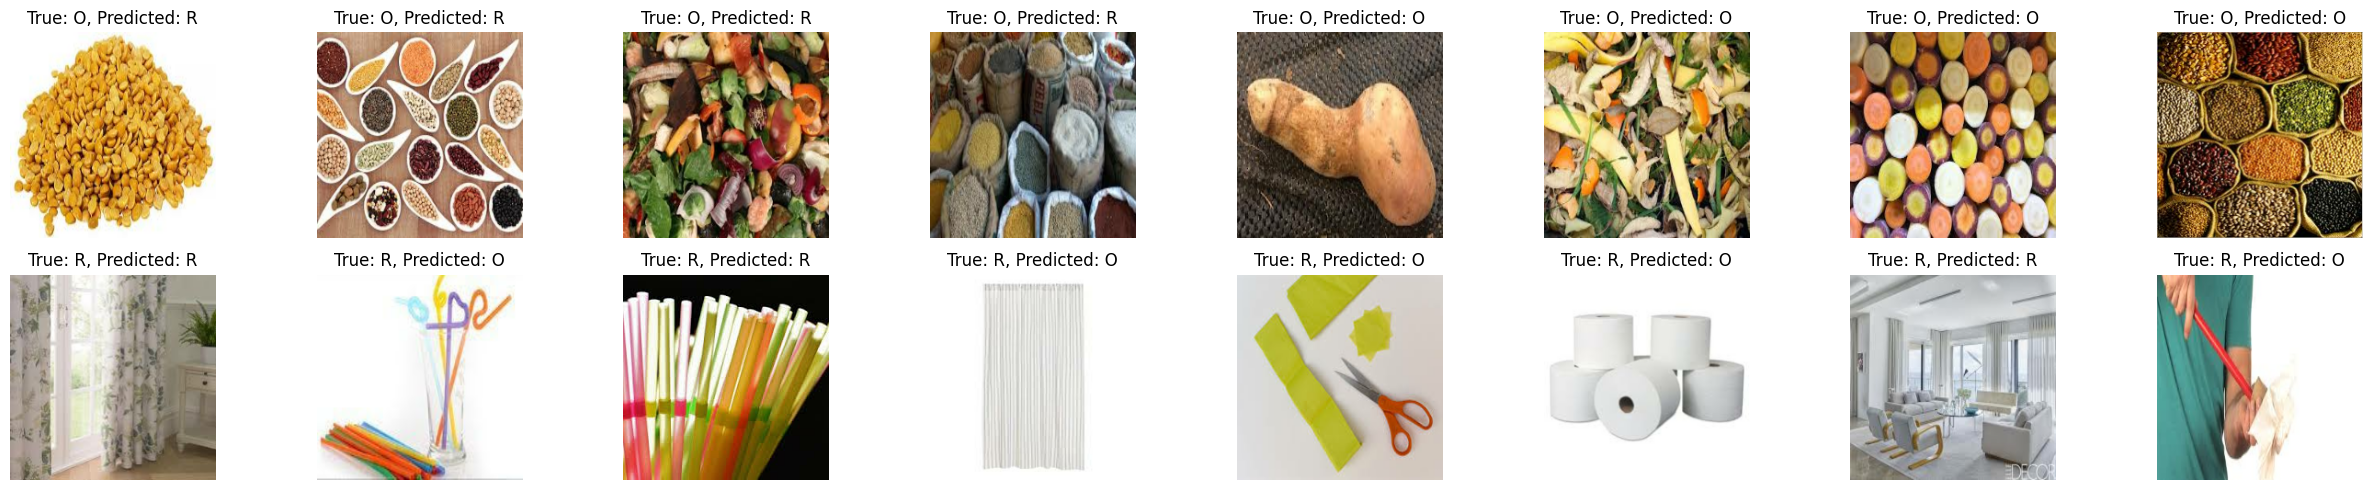

In [68]:
num_img = 8
plt.figure(figsize=(25, 5))

for class_label in [0, 1]:
    class_indices = np.where(test_labels == class_label)[0][:num_img]
    for i, index in enumerate(class_indices):
        image_path = test_paths[index]
        true_label = test_labels[index]
        predicted_label = test_predictions[index]
        image = loading_preprocessing_ImagePerdict(image_path)
        plt.subplot(2,num_img , class_label * num_img + i + 1)
        plt.imshow(image.numpy())
        P='O' if predicted_label==0 else 'R'
        T='O' if true_label==0 else 'R'
        plt.title(f"True: {T}, Predicted: {P}")
        plt.axis("off")

plt.tight_layout()
plt.show()

##Test it on Real data

1/1 [==============================] - 0s 40ms/step
Organic waste


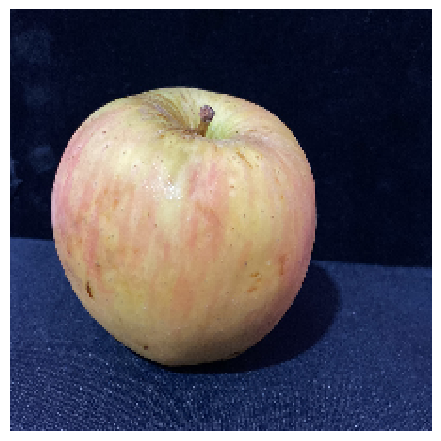

In [69]:
# Test Case:1 - ORGANIC

dic = test_generator.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/apple.png', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

def predict_prob(number):
  return [number[0],1-number[0]]

answer = np.array(list(map(predict_prob, model.predict(img))))
if answer[0][0] > 0.5:
    print("Recycle waste")
else:
    print("Organic waste")

1/1 [==============================] - 0s 26ms/step
Recycle waste


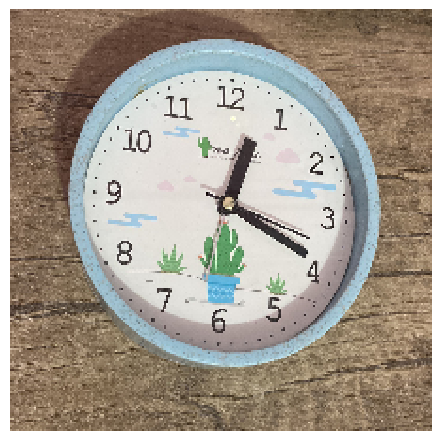

In [70]:
dic = test_generator.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/watch.png', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

def predict_prob(number):
  return [number[0],1-number[0]]

answer = np.array(list(map(predict_prob, model.predict(img))))
if answer[0][0] > 0.5:
    print("Recycle waste")
else:
    print("Organic waste")